# <span style="color:#F72585"><center>Regresión básica con tf.keras: API Sequential</center></span>

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Redes_Neuronales/Imagenes/gasolina.jpg" width="800" height="400" align="center" /> 
</center>   
</figure>
<center>

Fuente: <a href="https://commons.wikimedia.org/wiki/File:Dispensador_de_gasolina_viejo_en_San_Vicente.jpg">Cesar Pérez</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

</center>

## <span style="color:#4361EE">Introducción</span>

[Información general sobre Tensorflow](https://www.tensorflow.org/?hl=en).


<a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />Vea el cuaderno original en: TensorFlow.org</a>

En un problema de *regresión*, buscamos predecir la salida de un valor continuo como la probabilidad de un precio. En contraste en un problema de *Clasificación*, buscamos seleccionar una clase de una lista de clases (por ejemplo, en donde una imagen contenga una manzana o una naranja queremos reconocer cual es la fruta en la imagen).

En esta lección se usa el conjunto de datos clásico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y se construye un modelo para predecir la eficiencia en el consumo de la gasolina de vehículos de entre 1970 y 1980. Para hacer esto proveeremos el modelo con una descripción de muchos automóviles de ese periodo. Esta descripción incluye atributos como: cilindros, desplazamiento, potencia y peso.

En el ejemplo usaremos el API *Sequential* de `tf.keras`.

## <span style="color:#4361EE">Importa librerías requeridas</span>

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print(tf.__version__)

2.4.1


## <span style="color:#4361EE">El conjunto de Datos MPG</span>


El conjunto de datos MPG (millas por galón) está disponible en el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


## <span style="color:#4361EE">Lectura de los datos</span>


Primero descargamos el conjunto de datos desde la fuente.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/alvaro/.keras/datasets/auto-mpg.data'

Luego leemos los datos usando Pandas.

In [4]:
# nombres de las columnas
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

# lee el archivo, ques de tipo csv
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
 
# hace un copia de los datos
dataset = raw_dataset.copy()
# muestra los últimos registro leídos
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## <span style="color:#4361EE">Preprocesamiento</span>

### <span style="color:#4CC9F0">Detecta datos faltantes y elimina filas con faltantes</span>



El conjunto de datos tiene algunos valores faltantes en la variable *Horsepower*.

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

**Para** Mantener este tutorial inicial sencillo eliminemos las filas con datos faltantes. En la práctica de la vida diaria esto es algo que en general debe evitarse.

In [6]:
dataset = dataset.dropna()
print('Foprma de los datos: ', dataset.shape)

Foprma de los datos:  (392, 8)


### <span style="color:#4CC9F0">Codificación one-hot</span>


La columna de `"Origin"` realmente es categórica, no numérica. Entonces conviértala a un "one-hot":

In [7]:
# retira 'Origin' de dataset y lo entrega. Se recibe en la variable Origin
Origin = dataset.pop('Origin') 

In [8]:
dataset['USA'] = (Origin == 1)*1.0
dataset['Europe'] = (Origin == 2)*1.0
dataset['Japan'] = (Origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### <span style="color:#4CC9F0">Ejercicio</span>


Investigue como hacer esta codificación one-hot utilizando [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

### <span style="color:#4CC9F0">Dividir los datos en entrenamiento y test</span>


Ahora divida el conjunto de datos en un conjunto de entrenamiento y otro de pruebas.

Usaremos el conjunto de pruebas en la evaluación final de nuestro modelo.

In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_dataset.keys()

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

### <span style="color:#4CC9F0">Descriptivo de los datos</span>



Revise rápidamente la distribución conjunta de cada par de columnas del conjunto de entrenamiento.

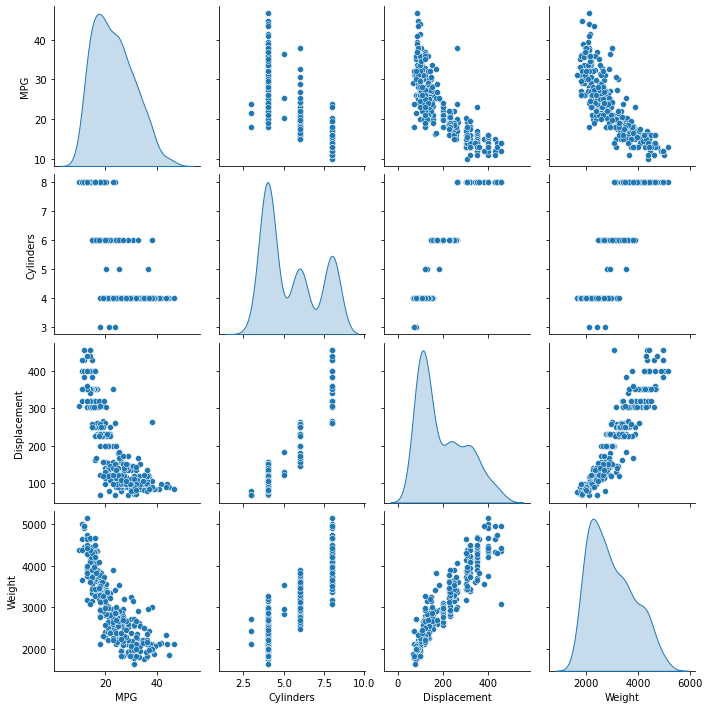

In [13]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

También revise las estadisticas descriptivas generales:

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Separe la variable objetivo de las caracteristicas. Esta  es la variable de respuesta en el modelo estadístico.

In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### <span style="color:#4CC9F0">Normalice los datos</span>


Revise otra vez el bloque de `train_stats` que se presentó antes y note la diferencia de rangos de cada característica.

Es una buena práctica normalizar variables que utilizan diferentes escalas y rangos. Aunque el modelo *podría* converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

```{admonition} Nota
:class: note
Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.
```

In [14]:
# función para normalizar los datos.
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# normaliza los datos
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [15]:
norm_train_stats = normed_train_data.describe()
norm_train_stats = norm_train_stats.transpose()
norm_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,1.824443e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,8.627211e-17,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-9.900078e-18,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-8.485781e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,-5.148041e-16,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.772791e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,7.920062e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,1.980016e-17,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,5.374328e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


Estos datos normalizados son los  que usaremos para entrenar el modelo.

```{admonition} Precaución
:class: warning
Las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato con los que se alimente al modelo, junto con la codificación one-hot que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

```

## <span style="color:#4361EE">Modelo matemático</span>

### <span style="color:#4CC9F0">Función predictora</span>

Supongamos que $\mathbf{x}_i \in \mathbb{R}^n$ representa al vector de datos de la muestra $i$ y que  $y_i$ es la respectiva etiqueta. El modelo predictivo es una red neuronal, la cual es una función $\text{rn}:\mathbb{R}^n \to \mathbb{R}$, con parámetros $\mathbf{w},b$. La predicción asociada a $\mathbf{x}_i$ se denota $\hat{y}_i$ y se define por

$$
\hat{y}_i = \text{rn}(\mathbf{x}_i).
$$

Para cualquier vector $\mathbf{x}$ en el espacio de características, su predicción se denota por $\hat{y} = \text{rn}(\mathbf{x})$.

### <span style="color:#4CC9F0">Función de pérdida</span>

La función predictiva tiene parámetros $\mathbf{w},b$, por lo que podemos denotarla de manera más genérica como $\text{rn}(\mathbf{x}|\mathbf{w},b)$. Si se tienen $n$ datos de entrenamiento, la función de pérdida error cuadrático medio (MSE)  es dada por

$$
\mathfrak{L}(\mathbf{w},b) = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2 = \frac{1}{n}\sum_{i=1}^n (\text{rn}(\mathbf{x}_i|\mathbf{w},b) - y_i)^2.
$$

### <span style="color:#4CC9F0">Función de activación Unidad de Rectificación Lineal (ReLU)</span>


*ReLu* es la función de activación más utilizada actualmente. Implementada principalmente en capas ocultas de la red neuronal. *ReLU* se define como

$$
f(x) = \text{ReLU}(x) = max(0,x),
$$
para $x\in \mathcal{R}$. 

#### <span style="color:#4CC9F0">Ejercicio</span>


Verifique que

1. $0\le f(x)< \infty$
2. $f'(x)= 1$ for $x > 0$, and  $f'(x)= 0$ for $x < 0$.

*ReLu* es menos costosa computacionalmente que *Tanh* y *sigmoide* porque involucra operaciones matemáticas más simples.  *ReLu* permite a la red aprender mucho más rápido que la funciones *sigmoide* y *Tanh*. El siguiente fragmento de código dibuja la función de activación *ReLU*.

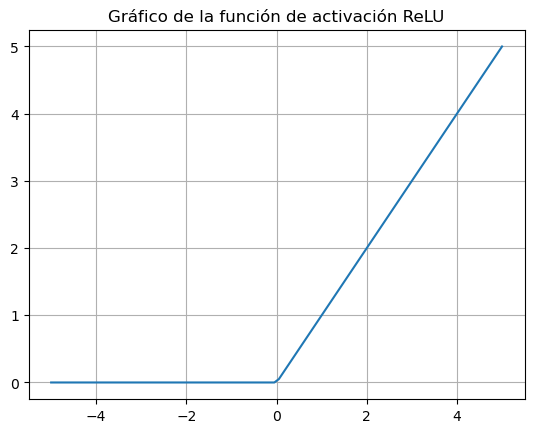

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def Relu(x):
    y= np.zeros(x.shape)
    return np.ndarray.flatten(np.max([[y],[x]], axis =0))

x = np.linspace(-5,5,100)
plt.title('Gráfico de la función de activación ReLU')
plt.plot(x,Relu(x))
plt.grid()
plt.show()

## <span style="color:#4361EE">Construcción del modelo Sequential con Keras</span>

Construyamos nuestro modelo, usando el API Sequential de Keras. Aquí, utilizaremos un modelo `Secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Como función de activación usaremos *ReLU* a la salida de cada capa densa. Podemos definir el modelo, es decir, la red neuronal como sigue:

In [18]:
model = keras.Sequential([
layers.Dense(64, activation='relu', input_shape=(normed_train_data.shape[1],)),
layers.Dense(64, activation='relu'),
layers.Dense(1)
])

Observe que el modelo es definido dentro de una lista, en donde cada elemento corresponde a una capa de la red.

### <span style="color:#4CC9F0">Compila</span>

Es necesario compilar el modelo para que Tensorflow construya el árbol de cálculo de la red, determine us parámetros y configure los objetos que usará en el entrenamiento como el optimizador, la funcipon de pérdida y las métricas de evaluación.

In [21]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

### <span style="color:#4CC9F0">Summary</span>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


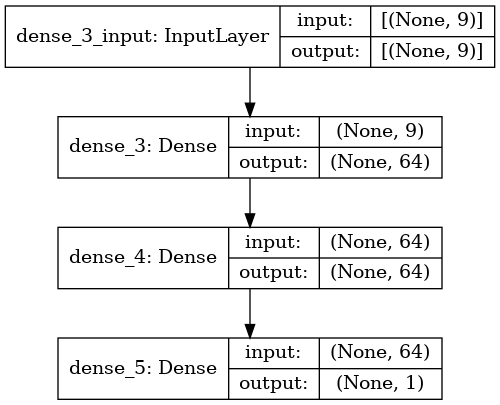

In [22]:
model.summary()
plot_model(model, to_file='../Imagenes/gasolina_model.png', 
           show_shapes=True)

## <span style="color:#4361EE">Entrena el modelo</span>

Entrene el modelo durante 1000 epochs y registre la precisión de entrenamiento y validación en el objeto `history`.

### <span style="color:#4CC9F0">Define un callback para interceptar las salida</span>

In [24]:
# Muestra el progreso del entrenamiento imprimiendo un solo punto para cada época completada
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

epochs = 1000

### <span style="color:#4CC9F0">Corre el entrenamiento</span>

Se corre el entrenamiento, guardando la historia de la pérdida y de la métricas tanto de entrenamiento como de validación para los análisis de convergencia y comportamiento general del entrenamiento.

In [25]:
history = model.fit(
  normed_train_data, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

2022-12-06 11:14:49.759414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-06 11:14:49.875902: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2694965000 Hz



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### <span style="color:#4CC9F0">Visualización del comportamiento del entrenamiento</span>

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.434761,0.991909,2.434761,7.162321,2.038158,7.162320,995
996,2.610642,1.014884,2.610642,7.414281,2.089263,7.414281,996
997,2.546142,1.010963,2.546142,7.179081,2.068915,7.179081,997
998,2.517135,1.008088,2.517135,7.223082,2.110130,7.223082,998
999,2.543185,1.020697,2.543185,7.671556,2.201153,7.671556,999


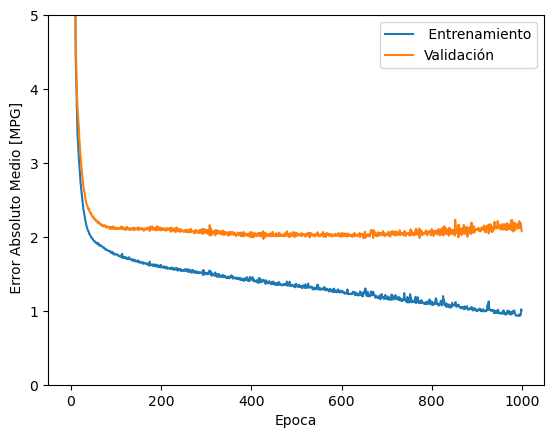

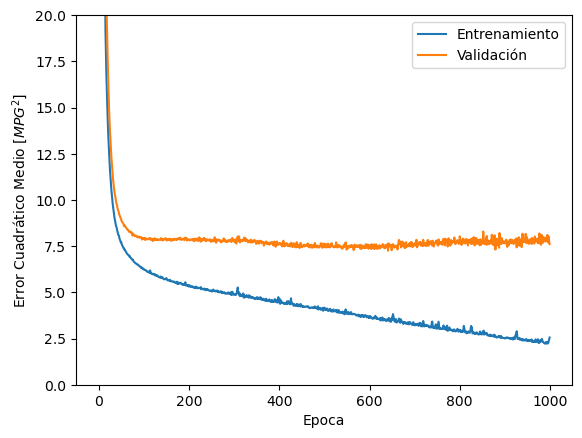

In [29]:
# función para mostrar pérdida y métricas
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['Epoca'] = history.epoch

    plt.figure()
    plt.xlabel('Epoca')
    plt.ylabel(' Error Absoluto Medio [MPG]')
    plt.plot(hist['Epoca'], hist['mae'],
           label=' Entrenamiento')
    plt.plot(hist['Epoca'], hist['val_mae'],
           label = 'Validación')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoca')
    plt.ylabel('Error Cuadrático Medio [$MPG^2$]')
    plt.plot(hist['Epoca'], hist['mse'],
           label='Entrenamiento')
    plt.plot(hist['Epoca'], hist['val_mse'],
           label = 'Validación')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Vamos a actualizar la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una devolución de llamada(callback)   de *EarlyStopping* que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puede obtener más información sobre esta devolución de llamada  en este [enlace](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


.............

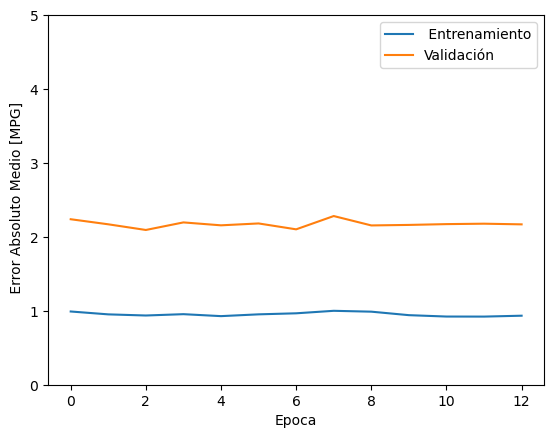

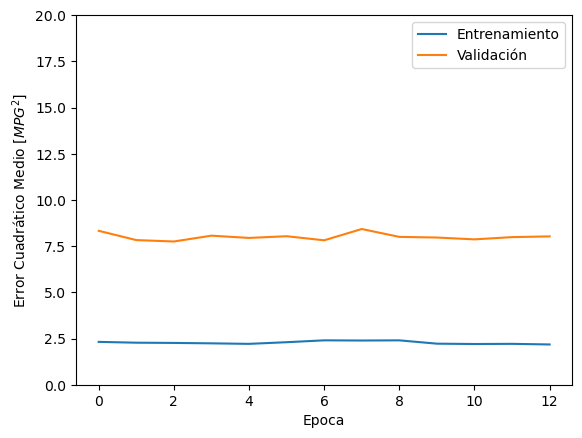

In [30]:
# El parámetro de paciencia (patience) es la cantidad de épocas para verificar la mejora.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? Le dejaremos esa decisión a usted.

Veamos qué tan bien generaliza el modelo al usar el conjunto **test**, el cual no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Error Aboluto Medio (conjunto de prueba): {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.7185 - mae: 2.1133 - mse: 7.7185
Error Aboluto Medio (conjunto de prueba):  2.11 MPG


## <span style="color:#4361EE">Predicciones</span>


Finalmente, prediga los valores de MPG utilizando datos en el conjunto de prueba:

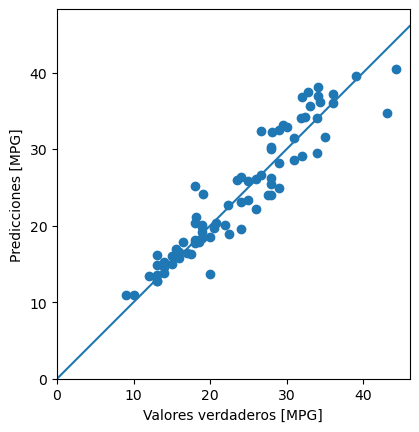

In [34]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Valores verdaderos [MPG]')
plt.ylabel('Predicciones [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Parece que nuestro modelo predice razonablemente bien. Demos un vistazo a la distribución de errores.

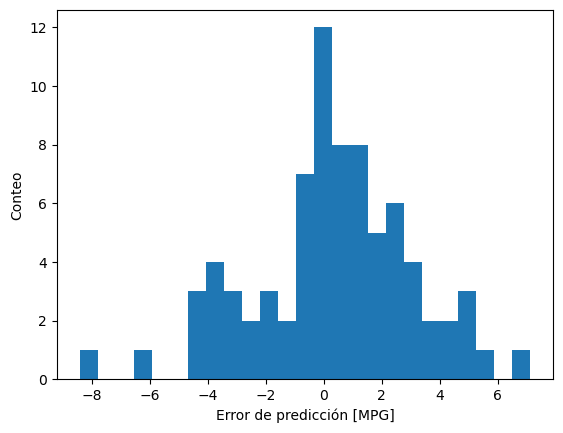

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción [MPG]")
_ = plt.ylabel("Conteo")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## <span style="color:#4361EE">Conclusión</span>


Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.